In [1]:
import ROOT as rt
import sys
import collections
from collections import OrderedDict
import uproot

import os
import scipy
import awkward as ak
import time
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import *

import numpy as np
from scipy.stats import norm
import math
import CMS_lumi, tdrstyle
style = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0


print(sys.version)

Welcome to JupyROOT 6.24/06
3.6.8 (default, Nov  2 2021, 13:01:57) 
[GCC 8.4.1 20200928 (Red Hat 8.4.1-1)]


# Load ntuples

In [2]:
%%time

fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()

# for data_year in ['2022','2023','all']:
for data_year in ['all']:

    # path = "/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/data/raw/"
    # fpath_bkg[data_year] = path + f"data_{data_year}_goodLumi.root"
    if data_year == 'all':path = f'/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data_all/v13/normalized/'
    else: path = f'/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data{data_year}/v13/normalized/'
    if data_year == '2022':fpath['data'+data_year] = path + "DisplacedJet-EXOCSCCluster_Run2022-PromptReco_goodLumi.root"
    elif data_year == '2023':fpath['data'+data_year] = path + "Muon-EXOCSCCluster_Run2023-PromptReco_goodLumi.root"
    elif data_year == 'all':fpath['data'+data_year] = path + "EXOCSCCluster_Run2022_2023_goodLumi.root"

fpath['sig'] = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v13/normalized/ggH_Hto2Sto4B_MH-125-MS-15-ctauS-1000_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root'
NEvents = {}

for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'].values()[0]
    # NEvents[k] = root_dir['NEvents'].counts()
    print("NEvents",NEvents[k])


dataall /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19//Data_all/v13/normalized/EXOCSCCluster_Run2022_2023_goodLumi.root
NEvents 34804216.0
sig /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/Run3/V1p19/MC_all/v13/normalized/ggH_Hto2Sto4B_MH-125-MS-15-ctauS-1000_TuneCP5_13p6TeV_powheg-pythia8_50000pb_weighted.root
NEvents 57555044.0
CPU times: user 400 ms, sys: 8.7 ms, total: 409 ms
Wall time: 408 ms


# apply selections

In [48]:
%%time


JET_PT_CUT = 30
MUON_PT_CUT = 30.0
N_RECHIT_CUT = 90

cscRechitClusterPhi0 = {}
cscRechitClusterPhi1 = {}
deltaPhi_cluster  = {}
cscRechitClusterDNN0  = {}
cscRechitClusterDNN1  = {}
cscRechitClusterTime0  = {}
cscRechitClusterTime1  = {}
cscRechitClusterSize0  = {}
cscRechitClusterSize1  = {}
weight = {}

region_list = ['invertDNN', 'oot', 'signal']
for region in region_list:
    for tree_k in tree.keys():
    #     if not k=='data_intime_BDTbin1': continue
        T = tree[tree_k]
        k = f'{region}_{tree_k}'


    ########### SELECTION: CLUSTERS ############
        me1 = (T['cscRechitClusterNRechitChamberPlus11'].array()+ T['cscRechitClusterNRechitChamberPlus12'].array()+\
        T['cscRechitClusterNRechitChamberMinus11'].array()+ T['cscRechitClusterNRechitChamberMinus12'].array())
        cscRechitClusterR = (T['cscRechitClusterX'].array()**2+T['cscRechitClusterY'].array()**2)**0.5
        L1 = L1_trg(cscRechitClusterR, np.abs(T['cscRechitClusterZ'].array()), np.abs(T['cscRechitClusterSize'].array()))

        #one cluster to pass trigger
        cluster0 = np.logical_and(T['cscRechitClusterTimeWeighted'].array() < 12.5, T['cscRechitClusterTimeWeighted'].array() > -5)
        cluster0 = cluster0 & L1
        cluster0 = cluster0 & (me1 ==0)
        cluster0 = cluster0 & (T['cscRechitClusterTimeSpreadWeightedAll'].array()<20)
        cluster0 = cluster0 & (T['cscRechitClusterJetVetoPt'].array()<30)
        cluster0 = cluster0 & np.logical_not((T['cscRechitClusterMuonVetoPt'].array() > 30) & T['cscRechitClusterMuonVetoGlobal'].array())    


        cluster1 = (me1 == 0)
        cluster1 = cluster1 & (T['cscRechitClusterTimeSpreadWeightedAll'].array()<20)
        cluster1 = cluster1 & (T['cscRechitClusterJetVetoPt'].array()<30)
        cluster1 = cluster1 & np.logical_not((T['cscRechitClusterMuonVetoPt'].array() > 30) & T['cscRechitClusterMuonVetoGlobal'].array())    
        # if 'oot' in region: cluster1 = cluster1 & (T['cscRechitClusterTimeWeighted'].array() < -12.5)
        # else:cluster1 = cluster1 & (T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array() < 0.96)



    ########### SELECTION: EVENTS ############
        sel_ev = T['HLT_CSCCSC'].array()
        sel_ev  = np.logical_and(sel_ev,np.sum(cluster0, axis = 1) >= 1)
        sel_ev  = np.logical_and(sel_ev,np.sum(cluster1, axis = 1) == 2)
        
        
        # if met_cat == 'lowMET':sel_ev = np.logical_and(sel_ev ,T['met'].array() < 150)
        # else: sel_ev = sel_ev & (T['met'].array() > 150) & (T['met'].array() < 200)
        sel_ev = np.logical_and(sel_ev ,T['met'].array() < 200)
        sel_ev = np.logical_and(sel_ev,T['nCscRechitClusters'].array()==2)
        # print(np.count_nonzero(temp), np.count_nonzero(sel_ev))

    ########### BRANCHES ############

       ##### event variables ##### 
        # make sure cluster0 and cluster1 index are different
        cluster1 = cluster1[sel_ev]
        cluster0 = cluster0[sel_ev]

        #remove cluster0 from cluster1 selection to make sure we select different clusters
        cluster0_index = list(np.argmax(cluster0, axis=1))
        cluster0_mask = ak.Array([[False if j == cluster0_index[i] else True for j in range(len(cluster1[i]))] for i in range(len(cluster1))])
        cluster1 = cluster0_mask & cluster1
                
        cscRechitClusterPhi0[k] = T['cscRechitClusterPhi'].array()[sel_ev][cluster0][:,0]
        cscRechitClusterPhi1[k] = T['cscRechitClusterPhi'].array()[sel_ev][cluster1][:,0]
        deltaPhi_cluster[k] = deltaPhi(np.array(cscRechitClusterPhi0[k]), np.array(cscRechitClusterPhi1[k]))
        cscRechitClusterDNN0[k] = T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array()[sel_ev][cluster0][:,0]
        cscRechitClusterDNN1[k] = T['cscRechitClusterDNN_bkgMC_plusBeamHalo'].array()[sel_ev][cluster1][:,0]
        cscRechitClusterTime0[k] = T['cscRechitClusterTimeWeighted'].array()[sel_ev][cluster0][:,0]
        cscRechitClusterTime1[k] = T['cscRechitClusterTimeWeighted'].array()[sel_ev][cluster1][:,0]
        cscRechitClusterSize0[k] = T['cscRechitClusterSize'].array()[sel_ev][cluster0][:,0]
        cscRechitClusterSize1[k] = T['cscRechitClusterSize'].array()[sel_ev][cluster1][:,0]
        
        sel = (np.abs(deltaPhi_cluster[k])>1.8)
        if 'oot' in region:
            sel = sel & (cscRechitClusterDNN0[k] > 0.96) & (cscRechitClusterDNN1[k] > 0.96) & (cscRechitClusterTime1[k]<-12.5)
        elif 'invertDNN' in region:
            sel = sel & (cscRechitClusterDNN0[k] > 0.96) & (cscRechitClusterDNN1[k] < 0.96) \
            & (cscRechitClusterTime1[k]>-5) & (cscRechitClusterTime1[k]<12.5)
        elif 'signal' in region:
            sel = sel & (cscRechitClusterDNN0[k] > 0.96) & (cscRechitClusterDNN1[k] > 0.96) \
            & (cscRechitClusterTime1[k]>-5) & (cscRechitClusterTime1[k]<12.5)
        else: assert(False)
            
        deltaPhi_cluster[k] = deltaPhi_cluster[k][sel]
        cscRechitClusterSize1[k] = cscRechitClusterSize1[k][sel]
        weight[k] = T['weight'].array()[sel_ev][sel]
        print("correlation between two variables:", k, scipy.stats.pearsonr(deltaPhi_cluster[k], cscRechitClusterSize1[k]))
        print("events in this region:", k, len(deltaPhi_cluster[k]))

correlation between two variables: invertDNN_dataall (-0.013189681108034541, 0.7663543003245654)
events in this region: invertDNN_dataall 510
correlation between two variables: invertDNN_sig (0.08841484119648836, 0.10261864414109327)
events in this region: invertDNN_sig 342
correlation between two variables: oot_dataall (-0.003822248661944534, 0.94119284776451)
events in this region: oot_dataall 375
correlation between two variables: oot_sig (0.20525068556755371, 0.8683980629643594)
events in this region: oot_sig 3
correlation between two variables: signal_dataall (0.06172041871091932, 0.42258514504589834)
events in this region: signal_dataall 171
correlation between two variables: signal_sig (-0.004952960303296888, 0.827328993314127)
events in this region: signal_sig 1942
CPU times: user 58.7 s, sys: 3.43 s, total: 1min 2s
Wall time: 1min 2s


## Create datacard with OOT data for optimization

In [49]:
data_key = 'oot_dataall'
signal_key = 'signal_sig'
a, b, c, d, pred = {}, {}, {}, {}, {}

outDataCardsDir="/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_1_0_pre4/src/HiggsAnalysis/MuonSystemLimit/combine/datacards_run3HMT/OOT_opt/"
tree_dir = outDataCardsDir.replace("datacards","limitTrees")

modelName="ggH_HToSSTobbbb_MH-125_MS-15_CTau1000"

sig_unc = {'ggH':[[0.2]*4]}
sig_unc_name = ['test']
signal_region = 'a'
prefix = 'csccsc_'

h = {
signal_key: rt.TH2D("","",20,100,300, 14,1.8,3.2),
data_key: rt.TH2D("","",20,100,300, 14,1.8,3.2),
}


for nhit_cut in np.arange(100,300,10):
    for dphi_cut in np.arange(1.8, 3.2, 0.1):
        
        k = signal_key
        for k in [data_key, signal_key]:
            
            if k == data_key: TF = len(cscRechitClusterSize1['signal_dataall'])/len(cscRechitClusterSize1['oot_dataall'])
            else: TF = 1
            a[k] = np.sum(weight[k][(cscRechitClusterSize1[k]>=nhit_cut) &  (np.abs(deltaPhi_cluster[k])>=dphi_cut)]) * TF
            b[k] = np.sum(weight[k][(cscRechitClusterSize1[k]>=nhit_cut) &  (np.abs(deltaPhi_cluster[k])<dphi_cut)]) * TF
            c[k] = np.sum(weight[k][(cscRechitClusterSize1[k]<nhit_cut) &  (np.abs(deltaPhi_cluster[k])<dphi_cut)]) * TF
            d[k] = np.sum(weight[k][(cscRechitClusterSize1[k]<nhit_cut) &  (np.abs(deltaPhi_cluster[k])>=dphi_cut)]) * TF
            if c[k] == 0: pred[k] = 999
            else: pred[k] = b[k]*d[k]/c[k]
            
            if k == data_key:
                if b[k] < 1 or c[k] < 1 or d[k] < 1:continue
                unc_pred = (TF/c[k] + TF/b[k] + TF/d[k])**0.5*pred[k]
                # print(k,unc_pred,pred[k],a[k],b[k],c[k],d[k])
        if b[data_key] < 1 or c[data_key] < 1 or d[data_key] < 1:continue
        # print(nhit_cut, dphi_cut, a[signal_key], pred[data_key], a[signal_key]/pred[data_key], unc_pred, pred[data_key])
        
        
        xbin = h[data_key].GetXaxis().FindBin(nhit_cut)
        ybin = h[data_key].GetYaxis().FindBin(dphi_cut)
        h[data_key].SetBinContent(xbin,ybin,pred[data_key])
        h[signal_key].SetBinContent(xbin,ybin,a[signal_key])
            
        card_name = f'nhits{nhit_cut}_dphi'+str(round(dphi_cut,1)).replace(".","p")
        
        ## create datacards ##
        make_datacard_2tag(
        outDataCardsDir,
        card_name,
        {'ggH':[a[signal_key],b[signal_key],c[signal_key],d[signal_key]]}, #signal rate
        a[signal_key], 
        [pred[data_key],b[data_key],c[data_key],d[data_key]], #bkg rate
        [a[data_key],b[data_key],c[data_key],d[data_key]], #observation
        [unc_pred/pred[data_key]], 
        ['syst'], 
        sig_unc, 
        sig_unc_name,
        signal_region, 
        prefix
        )
        
        
        # break

# plot signal/bkg

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


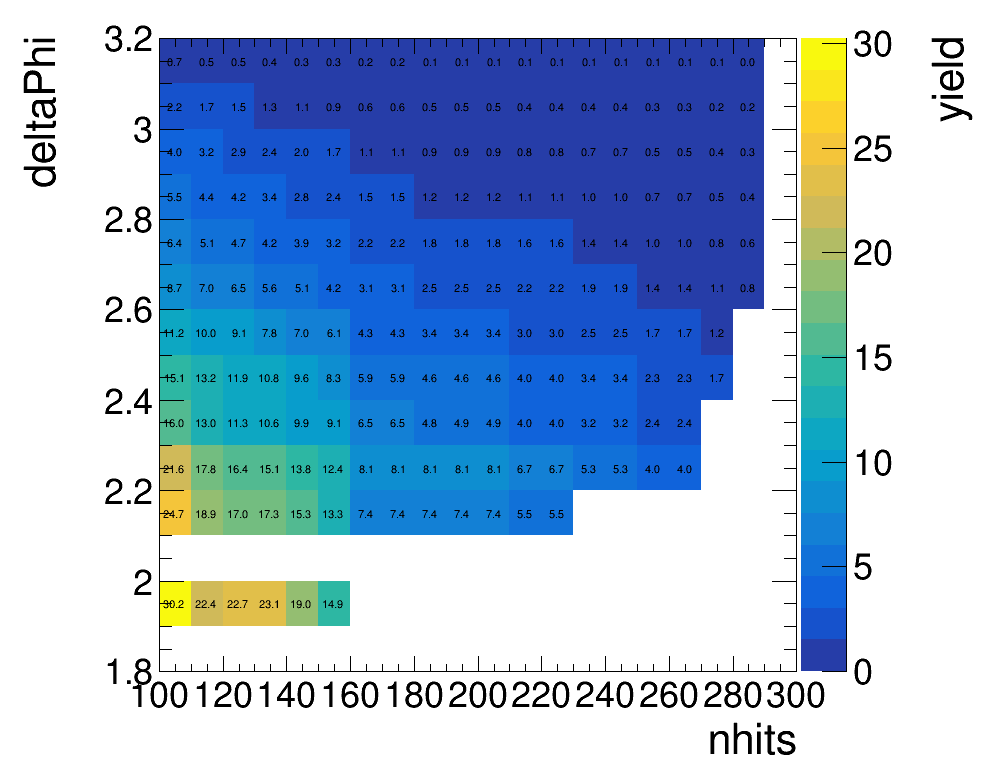

In [54]:
rt.gStyle.SetPaintTextFormat("1.1f");
c = rt.TCanvas('c','c', 1000, 800)

k = signal_key
k = data_key
h[k].GetXaxis().SetTitle("nhits")
h[k].GetYaxis().SetTitle("deltaPhi")
h[k].GetZaxis().SetTitle("yield")
h[k].GetZaxis().SetTitleOffset(1.1)
h[k].SetMarkerSize(0.8)

h[k].Draw("colz text")
c.SetRightMargin(0.2)
c.Draw()

## Plot combine result

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


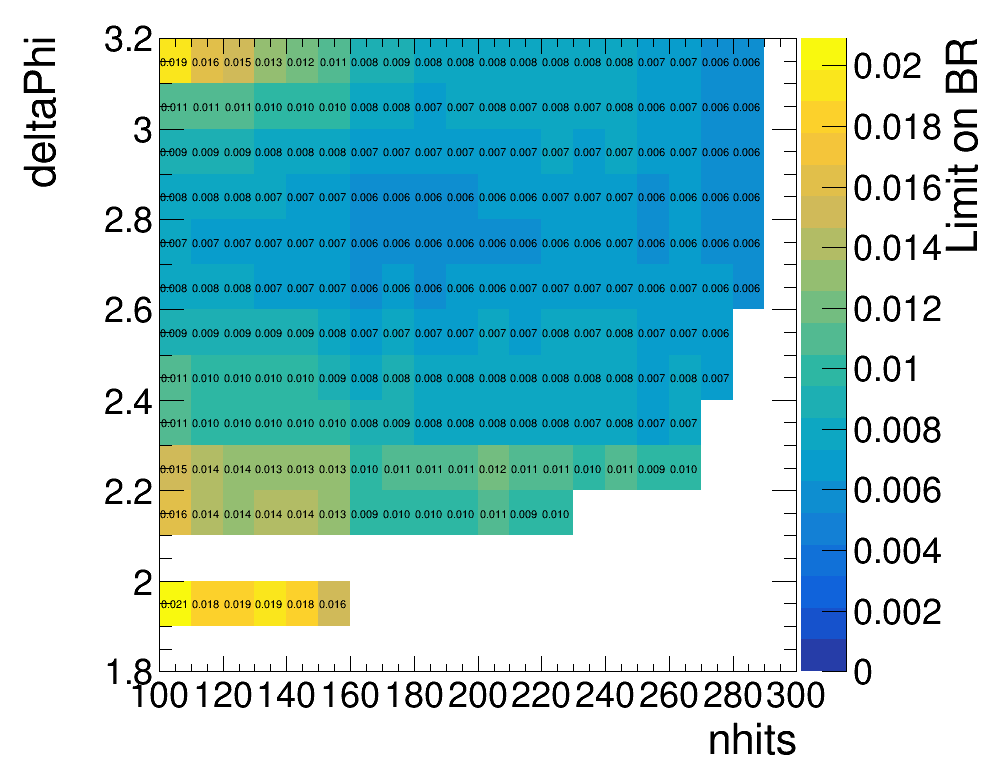

In [55]:
rt.gStyle.SetPaintTextFormat("1.3f");

c = rt.TCanvas('c','c', 1000, 800)
h_opt = rt.TH2D("","",20,100,300, 14,1.8,3.2)

for nhit_cut in np.arange(100,300,10):
    for dphi_cut in np.arange(1.8, 3.2, 0.1):
        
        ###### open datacard and limit ######
        card_name = f"nhits{nhit_cut}_dphi"+str(round(dphi_cut,1)).replace(".","p") 
        if not os.path.isfile(f"{outDataCardsDir}/{card_name}.txt"):continue
        signal_norm = readNorm(f"{outDataCardsDir}/{card_name}.txt")
        
        tree_name = f"higgsCombine.{card_name}.AsymptoticLimits.mH120.root"
        limitTree = tree_dir + '/' + tree_name
        if not os.path.isfile(limitTree):continue
        if len(uproot.open(limitTree).keys()) == 2:
                T = uproot.open(limitTree)['limit']                
                if len(np.array(T['limit'].array())>0):limit = np.array(T['limit'].array())/signal_norm
        
        
        xbin = h_opt.GetXaxis().FindBin(nhit_cut)
        ybin = h_opt.GetYaxis().FindBin(dphi_cut)
        h_opt.SetBinContent(xbin,ybin,limit[2])
        # if limit[2]<0.008: print(nhit_cut, dphi_cut, limit[2], h[data_key].GetBinContent(xbin,ybin), h[signal_key].GetBinContent(xbin,ybin))

h_opt.SetMarkerSize(0.8)
h_opt.GetXaxis().SetTitle("nhits")
h_opt.GetYaxis().SetTitle("deltaPhi")
h_opt.GetZaxis().SetTitle("Limit on BR")
h_opt.GetZaxis().SetTitleOffset(1.2)
h_opt.Draw("colz text")
c.SetRightMargin(0.2)
c.Draw()

invertDNN_dataall 510.0 510
oot_dataall 375.0 375
signal_dataall 169.0 171
0.17181062698364258


Info in <TCanvas::Print>: png file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/nhits.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/nhits.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/nhits.C has been generated
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/nhits.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/nhits.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots

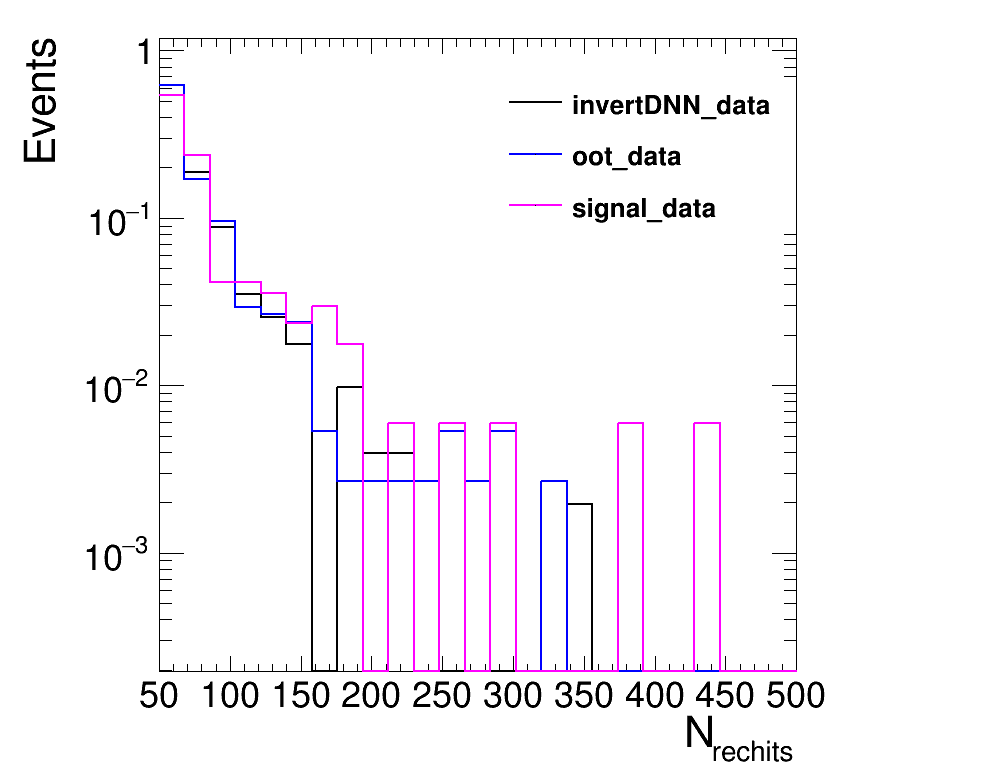

In [63]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
leg = rt.TLegend(0.5,0.7,0.8,0.9)
leg.SetBorderSize(0)
plot_var = [cscRechitClusterSize1, deltaPhi_cluster]
axis = ['N_{rechits}','#Delta#phi',]
name = ['nhits','dphi']
bins = [[25,50,500],[25,1.8,3.2]]

plot_index = 0

for i, k in enumerate(plot_var[plot_index].keys()):
    if not 'dataall' in k:continue
    # h = create_TH2D(np.column_stack(( np.array(cscRechitClusterSize1[k]), np.abs(deltaPhi_cluster[k]))),
                   # axis_title = ['N_{rechits}','#Delta#phi','Events'], binning=[25,50,500,25,1.8,3.2])
    
    h[k] = create_TH1D( np.array(plot_var[plot_index][k]), axis_title = [axis[plot_index],'Events'], binning=bins[plot_index])

    if plot_index == 0:h[k].SetMinimum(0.1)
    else: h[k].SetMinimum(500)
    h[k].SetLineColor(std_color_list[i])
    leg.AddEntry(h[k],k.replace('all',''))
    h[k].DrawNormalized('hist same')
    
    c.SetRightMargin(0.2)

    print(k, h[k].Integral(), len(cscRechitClusterSize1[k]))
    # if selog: 
    if plot_index == 0:c.SetLogy()
    leg.Draw()
    c.Draw()

    c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/"+name[plot_index]+".png")
    c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/"+name[plot_index]+".pdf")
    c.SaveAs("/storage/af/user/christiw/login-1/christiw/LLP/Run3/CMSSW_14_0_1/src/mds_analysis/plots/ABCD/"+name[plot_index]+".C")
    



print(time.time()-start_t)